In [51]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import zscore

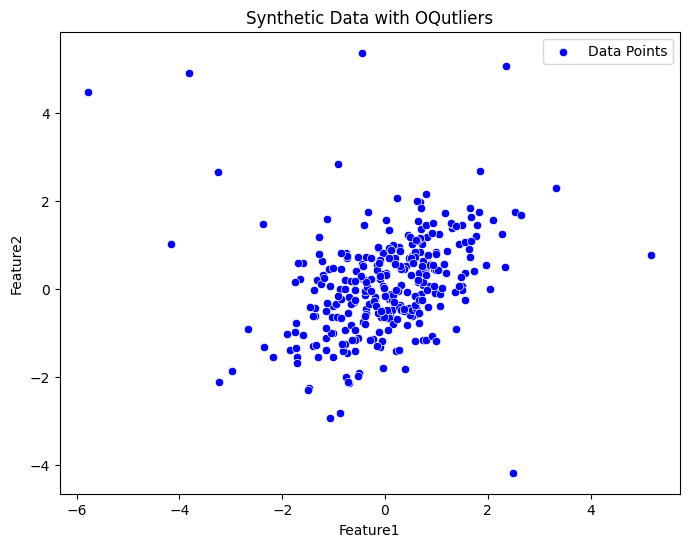

In [52]:
np.random.seed(42)
n_samples = 300
mean = [0,0]
cov = [[1, 0.5], [0.5, 1]]
data_normal = np.random.multivariate_normal(mean, cov, n_samples)

n_outliers = 15
data_outliers = np.random.uniform(low=-6, high=6, size=(n_outliers, 2))

data_all = np.vstack([data_normal, data_outliers])
df = pd.DataFrame(data_all, columns=[ 'Feature1', 'Feature2'])

plt.figure(figsize=(8, 6)) # Set the size of the plot
sns.scatterplot(x='Feature1', y='Feature2', data=df, color='blue', label='Data Points')
plt.title('Synthetic Data with OQutliers') # Title of the plot
plt.xlabel('Feature1') # Label for the x-axis
plt.ylabel('Feature2') # Label for the y-axis
plt.legend() # Display legend on the plot
plt.show() # Render the plot 



In [53]:
df['zs_1'] = zscore(df['Feature1'])
df['zs_2'] = zscore(df['Feature2'])
df.head()

,Feature1,Feature2,zs_1,zs_2
0,-0.361035,-0.499299,-0.312462,-0.499231
1,-1.322430,0.200600,-1.138197,0.104255
2,0.319851,0.085714,0.272347,0.005195
3,-1.751356,-0.983921,-1.506599,-0.917094
4,0.135297,0.677857,0.113834,0.515767


In [59]:
thrs = 2.5
df['is_outlier'] = (df[['zs_1', 'zs_2']].abs() > thrs).any(axis=1) 
df.head()

,Feature1,Feature2,zs_1,zs_2,is_outlier
0,-0.361035,-0.499299,-0.312462,-0.499231,False
1,-1.322430,0.200600,-1.138197,0.104255,False
2,0.319851,0.085714,0.272347,0.005195,False
3,-1.751356,-0.983921,-1.506599,-0.917094,False
4,0.135297,0.677857,0.113834,0.515767,False


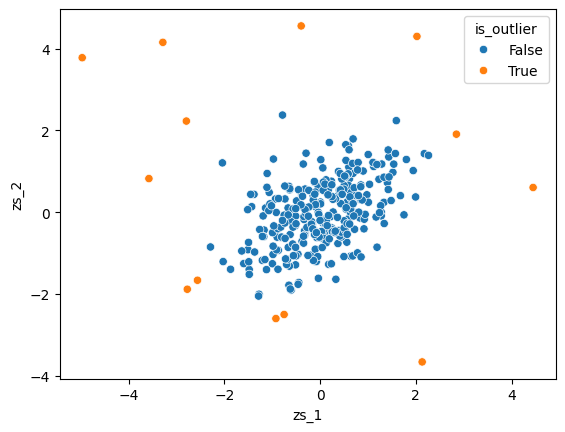

In [60]:
sns.scatterplot(x='zs_1', y='zs_2', data=df, hue="is_outlier")
plt.show()

In [61]:
df['is_outlier'][df.is_outlier == True].count()

np.int64(13)

In [62]:
df.is_outlier.sum()

np.int64(13)

# IQR Method

In [71]:
Q1 = df[['Feature1', 'Feature2']].quantile(0.25)
Q3 = df[['Feature1', 'Feature2']].quantile(0.75)

IQR = Q3 - Q1

lb = Q1 - 1.5*IQR
ub = Q3 + 1.5*IQR

df["IQR_outlier_is"] = ((df[['Feature1', 'Feature2']] < lb)|(df[['Feature1', 'Feature2']] > ub)).any(axis=1)
df

,Feature1,Feature2,zs_1,zs_2,is_outlier,IQR_outlier_is
0,-0.361035,-0.499299,-0.312462,-0.499231,False,False
1,-1.322430,0.200600,-1.138197,0.104255,False,False
2,0.319851,0.085714,0.272347,0.005195,False,False
3,-1.751356,-0.983921,-1.506599,-0.917094,False,False
4,0.135297,0.677857,0.113834,0.515767,False,False
...,...,...,...,...,...,...
310,5.185419,0.781598,4.451351,0.605218,True,True
311,2.359810,5.069993,2.024454,4.302867,True,True
312,2.486864,-4.169531,2.133579,-3.663872,True,True
313,0.915460,1.280581,0.783911,1.035463,False,False


In [73]:
df.IQR_outlier_is[df.IQR_outlier_is==True].count()

np.int64(14)

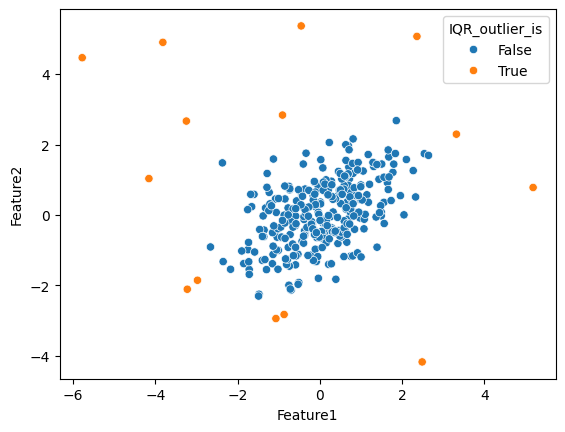

In [74]:
sns.scatterplot(x="Feature1", y="Feature2", data = df, hue="IQR_outlier_is")
plt.show()

# KNN Method

In [75]:
from sklearn.neighbors import NearestNeighbors

In [76]:
k = 7
nb = NearestNeighbors(n_neighbors=k)
nb.fit(df[['Feature1', 'Feature2']])

NearestNeighbors(n_neighbors=7)

In [83]:
distances, indices = nb.kneighbors()

In [85]:
print(distances)

[[0.05447583 0.07649262 0.10855598 ... 0.21140504 0.21565846 0.23590597]
 [0.10921282 0.15544468 0.15733609 ... 0.28967424 0.33979057 0.35079633]
 [0.14949517 0.1526678  0.18580018 ... 0.293041   0.30203955 0.32505508]
 ...
 [3.14808652 3.32980161 3.43678865 ... 3.46480187 3.47086194 3.47272961]
 [0.14003538 0.14335717 0.21257728 ... 0.22641499 0.25513666 0.26320805]
 [1.22475736 1.26736741 1.37871059 ... 1.57198587 1.6993897  1.75429772]]


In [86]:
df["KNN_avg_distance"] = distances[:, 1:].mean(axis=1)
df.head()

,Feature1,Feature2,zs_1,zs_2,is_outlier,IQR_outlier_is,KNN_avg_distance
0,-0.361035,-0.499299,-0.312462,-0.499231,False,False,0.167481
1,-1.322430,0.200600,-1.138197,0.104255,False,False,0.254475
2,0.319851,0.085714,0.272347,0.005195,False,False,0.254251
3,-1.751356,-0.983921,-1.506599,-0.917094,False,False,0.349198
4,0.135297,0.677857,0.113834,0.515767,False,False,0.179665


In [87]:
thrs = np.percentile(df["KNN_avg_distance"], 95)
thrs

np.float64(0.8483877229945916)

In [88]:
df["KNN_outlier_is"] = df['KNN_avg_distance'] > thrs
df.head()

,Feature1,Feature2,zs_1,zs_2,is_outlier,IQR_outlier_is,KNN_avg_distance,KNN_outlier_is
0,-0.361035,-0.499299,-0.312462,-0.499231,False,False,0.167481,False
1,-1.322430,0.200600,-1.138197,0.104255,False,False,0.254475,False
2,0.319851,0.085714,0.272347,0.005195,False,False,0.254251,False
3,-1.751356,-0.983921,-1.506599,-0.917094,False,False,0.349198,False
4,0.135297,0.677857,0.113834,0.515767,False,False,0.179665,False


In [89]:
print(f'KNN method outliers: {df['KNN_outlier_is'].sum()}')

KNN method outliers: 16


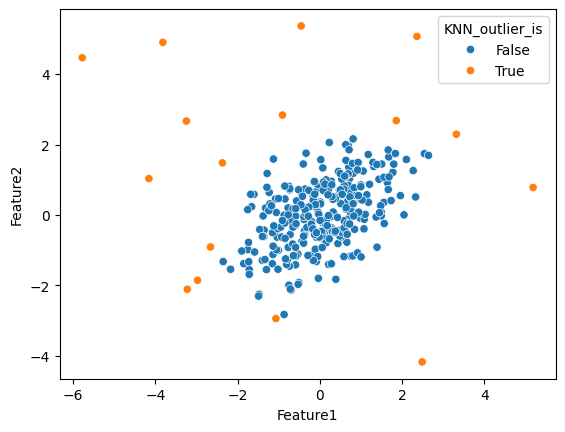

In [90]:
sns.scatterplot(x="Feature1", y="Feature2", data=df, hue="KNN_outlier_is")
plt.show()